In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr

from ssmdm.ramping import Ramping
from ssmdm.misc import smooth

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("ticks")
sns.set_context("talk")
from ssm.util import one_hot, softplus
from ssm.primitives import blocks_to_full
npr.seed(0)

In [2]:
# setup parameters
K = 2
M = 5
N = 15
beta = np.array([-0.01,-0.0025,0.0,0.01,0.015])
log_sigma_scale = np.log(1e-3)
x0 = 0.5
bin_size = 0.01

In [3]:
# initialize model
latent_ramp = Ramping(N, K=K, D=1, M=M,
                      dynamics_kwargs={"beta":beta, "log_sigma_scale":log_sigma_scale, "x0":x0},
                      emissions_kwargs={"bin_size":bin_size})
latent_ramp.emissions.Cs[0] = 40.0 + 3.0 * npr.randn(N,1)

In [4]:
# Simulate data
numTrials = 100

ys = []
xs = []
zs = []
us = []
cohs = []

# sample from model
for tr in range(numTrials):

    coh = npr.randint(M)
    u_tr = one_hot(coh,M)
    tr_length = npr.randint(50)+50
    u = u_tr * np.ones((tr_length,1))
    T = np.shape(u)[0]

    z, x, y = latent_ramp.sample(T, input=u)

    zs.append(z)
    xs.append(x)
    ys.append(y)
    us.append(u)
    cohs.append(coh)

cohs = np.array(cohs)

In [5]:
def initialize_ramp(ys,cohs, bin_size):
    coh5 = np.where(cohs==4)[0]
    y_end = np.array([y[-10:] for y in ys])
    y_end_5 = y_end[coh5]
    C = np.mean(y_end_5,axis=(0,1)) / bin_size
    y0_mean = np.mean([y[0:2] for y in ys],axis=0) / bin_size
    x0 = np.mean(np.divide(y0_mean, C))
    return C, x0

In [6]:
# initialize
beta = np.array([-0.005,-0.0025,0.0,0.01,0.02]) + 0.01*npr.randn(5)
log_sigma_scale = np.log(5e-4+2.5e-3*npr.rand())
C, x0 = initialize_ramp(ys, cohs, bin_size)

test_ramp = Ramping(N, K=K, D=1, M=M,
                    dynamics_kwargs={"beta":beta, "log_sigma_scale":log_sigma_scale, "x0":x0},
                    emissions_kwargs={"bin_size":bin_size})
test_ramp.emissions.Cs[0] =  C.reshape((N,1))

In [7]:
# fit model
q_elbos, q_lem = test_ramp.fit(ys, inputs=us, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               variational_posterior_kwargs={"initial_variance":1e-4},
                               alpha=0.5, num_iters=50, initialize=False)

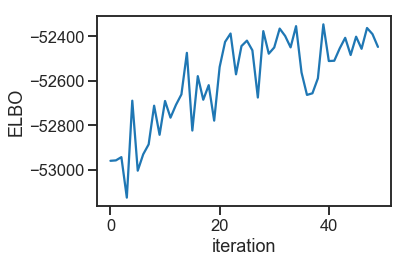

In [8]:
plt.figure()
plt.plot(q_elbos[1:])
plt.plot()
plt.ylabel("ELBO")
plt.xlabel("iteration")
plt.tight_layout()

In [9]:
def plot_posterior_spikes(q,model,ys,us,tr=0):

    q_lem_x = q.mean_continuous_states[tr]
    J_diag = q._params[tr]["J_diag"]
    J_lower_diag= q._params[tr]["J_lower_diag"]
    J = blocks_to_full(J_diag, J_lower_diag)
    Jinv = np.linalg.inv(J)
    q_lem_std = np.sqrt(np.diag(Jinv))

    q_z = q_lem.mean_discrete_states[tr][0]
    q_lem_z = np.argmax(q_z,axis=1)
    # q_lem_z = model.most_likely_states(q_lem_x, ys[tr])

    f, (a0, a1, a2) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1, 3.5, 1]}, figsize=[8,6])

    yhat = model.smooth(q_lem_x, ys[tr], input=us[tr])
    zhat = np.argmax(q.mean_discrete_states[tr][0],axis=1)
    a0.imshow(np.row_stack((zs[tr], zhat)), aspect="auto", vmin=0, vmax=1)
    a0.set_xticks([])
    a0.set_yticks([0,1])
    a0.set_yticklabels(["$z$", "$\hat{z}$"])
    a0.set_xlim([0,ys[tr].shape[0]-1])
    a1.plot(xs[tr],'b',label="true")
    a1.plot(q_lem_x,'k',label="inferred")
    a1.fill_between(np.arange(np.shape(ys[tr])[0]),(q_lem_x-q_lem_std*2.0)[:,0], (q_lem_x+q_lem_std*2.0)[:,0], facecolor='k', alpha=0.3)
    for j in range(5):
        x_sample = q.sample_continuous_states()[tr]
        a1.plot(x_sample, 'k', alpha=0.3)
    a1.plot(np.array([0,np.shape(ys[tr])[0]]),np.array([1.0,1.0]),'k--', linewidth=1)
    a1.set_ylim([-0.1,1.1])
    a1.set_ylabel("$x$")
    a1.set_xlim([0,ys[tr].shape[0]-1])
    a1.legend()
    a2.set_ylabel("$y$")
    for n in range(ys[tr].shape[1]):
        a2.eventplot(np.where(ys[tr][:,n]>0)[0], linelengths=0.5, lineoffsets=1+n,color='k')
    sns.despine()
    a2.set_yticks([])
    a2.set_xlim([0,ys[tr].shape[0]-1])
    plt.tight_layout()

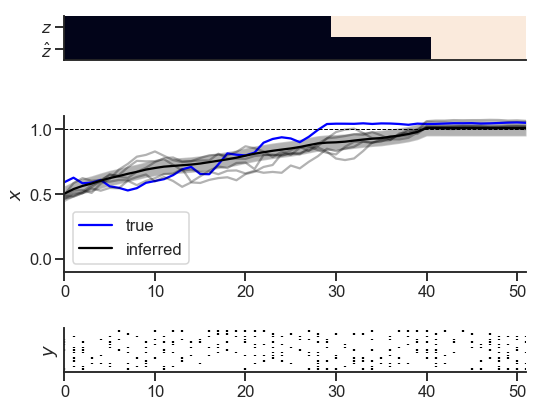

In [10]:
tr = npr.randint(numTrials)
plot_posterior_spikes(q_lem,test_ramp,ys,us,tr=tr)